# T-Money 택시수요 예측 - 시계열 예측    
  

선릉역 반경 150m 의 택시승차 건수를 FourierTransform 을 사용한 주파수 주출 및 미래예측

## 필요 모듈 import

In [555]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from scipy import stats
from scipy import fftpack
from scipy.signal import find_peaks

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

## 데이터 로드

### 데이터 로드

In [951]:
taxi = pd.read_csv("data/T-Money/seolleung_dataset.csv", parse_dates=["o_time"])
taxi['hour'] = taxi['o_time'].dt.hour
taxi['ytt'] = taxi[['yesterday', 'today', 'tomorrow']].apply(lambda x: ''.join(x.astype(str)), axis=1)
taxi = taxi[['o_time', 'hour', 'ytt', 'temp', 'windspeed', 'humidity', 'cloud', 'precipitation', 
             'snowcover', 'visibility', 'user', 'count']]
taxi.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12


### 명목형 변수 (hour, ytt) type 카테고리형으로 변경

In [602]:
taxi['hour'] = taxi['hour'].astype('category')
taxi['ytt'] = taxi['ytt'].astype('category')
print(taxi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 13 columns):
o_time           4368 non-null datetime64[ns]
hour             4368 non-null category
ytt              4368 non-null category
temp             4368 non-null float64
windspeed        4368 non-null float64
humidity         4368 non-null int64
cloud            4368 non-null float64
precipitation    4368 non-null float64
snowcover        4368 non-null float64
visibility       4368 non-null int64
user             4368 non-null float64
count            4368 non-null int64
residual         4368 non-null float64
dtypes: category(2), datetime64[ns](1), float64(7), int64(3)
memory usage: 385.2 KB
None


## 패턴분류

### FFT를 이용한 주파수 분해

__데이터 생성__

In [8]:
fft_data = taxi['count']
fft_data

o_time
2018-10-01 00:00:00     52
2018-10-01 01:00:00     17
2018-10-01 02:00:00     10
2018-10-01 03:00:00     13
2018-10-01 04:00:00     12
2018-10-01 05:00:00      8
2018-10-01 06:00:00     14
2018-10-01 07:00:00     31
2018-10-01 08:00:00    148
2018-10-01 09:00:00    130
2018-10-01 10:00:00     94
2018-10-01 11:00:00     89
2018-10-01 12:00:00    107
2018-10-01 13:00:00     95
2018-10-01 14:00:00     82
2018-10-01 15:00:00     97
2018-10-01 16:00:00     88
2018-10-01 17:00:00     80
2018-10-01 18:00:00     75
2018-10-01 19:00:00     88
2018-10-01 20:00:00    112
2018-10-01 21:00:00    120
2018-10-01 22:00:00    170
2018-10-01 23:00:00    147
2018-10-02 00:00:00    193
2018-10-02 01:00:00    100
2018-10-02 02:00:00     53
2018-10-02 03:00:00     33
2018-10-02 04:00:00     37
2018-10-02 05:00:00     31
                      ... 
2019-03-30 18:00:00     54
2019-03-30 19:00:00     42
2019-03-30 20:00:00     61
2019-03-30 21:00:00     46
2019-03-30 22:00:00     57
2019-03-30 23:00:00  

#### FFT

In [909]:
# Sampling Rate 365Hz 이므로, 1개의 시간간격은 1/365
T = 1.0 / 8760

# Sampling Count
N = fft_data.count()

# The FFT of the signal
yf = fftpack.fft(fft_data)

# And the power (yf is of complex dtype)
power = np.abs(yf)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(N, d=T)

# Focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]

#freqs
a = power[:len(freqs)]
a[0] = 0

result = pd.DataFrame({'frequency':freqs, 'power':a, 'period':8760/freqs})

#### 결과 그래프

In [650]:
# Plot the FFT power
def plot_stem_freq(data):
    plt.figure(figsize=(16, 4))
    plt.grid()
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.stem(data['frequency'], data['power'], use_line_collection=True)

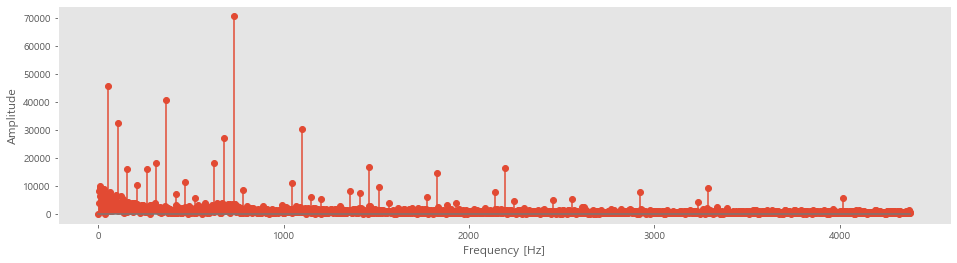

In [910]:
plot_stem_freq(result)

#### 상위추출

In [913]:
365/2

182.5

In [918]:
8760/12

730.0

In [908]:
365*24

8760

      frequency         power      period  order
364  732.005495  70618.084182   11.967123    1.0
26    54.148352  45652.316449  161.777778    2.0
182  367.005495  40794.225590   23.868852    3.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



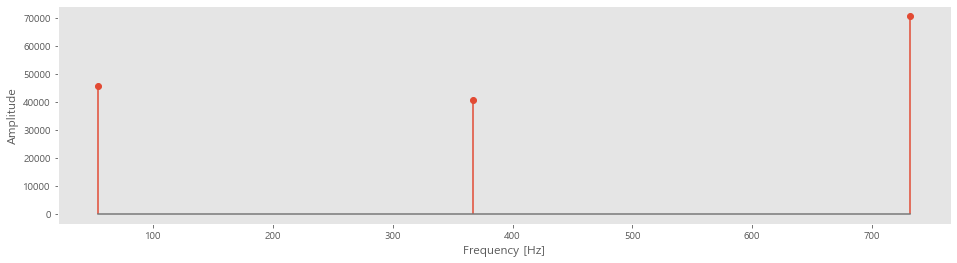

In [912]:
std = result['power'].std()
mean = result['power'].mean()

best = result[np.abs(result['power']-mean) > std * 2.0]
#best= best[19 < best['frequency']]
#best= best[best['frequency'] < 90]
best['order'] = best['power'].rank(ascending=False)
best = best[best['order'] < 4]
plot_stem_freq(best)
print(best.sort_values(by=['order'], axis=0))

In [125]:
low_freq_fft[np.isin(np.abs(sample_freq),best['frequency'],invert=True)] = 0

#### min_freq ~ max_freq 사이만 사용 

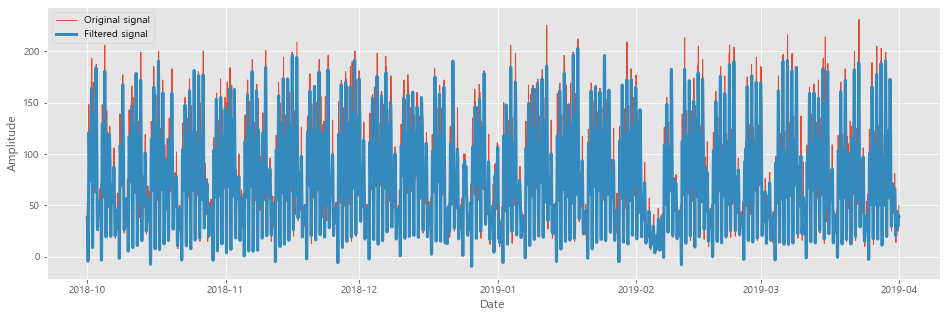

In [945]:
max_freq = 730*2 #np.max(best['frequency'].values)
min_freq = np.min(best['frequency'].values)

freq = best.frequency.values

low_freq_fft = yf.copy()
#low_freq_fft[(np.abs(sample_freq) > 0) & (np.isin(np.abs(sample_freq),best['frequency'],invert=True))] = 0
low_freq_fft[np.abs(sample_freq) > max_freq] = 0
#low_freq_fft[(np.abs(sample_freq) != 0)] = 0# & (np.abs(sample_freq) < min_freq)] = 0

base_line = fftpack.ifft(low_freq_fft).real

fft_result = fft_data.to_frame()
fft_result['base_line'] = base_line

plt.figure(figsize=(16, 5))
plt.plot(fft_result.index, fft_result['count'], linewidth=1, label='Original signal')
plt.plot(fft_result.index, fft_result['base_line'], linewidth=3, label='Filtered signal')
plt.xlabel('Date')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.show()

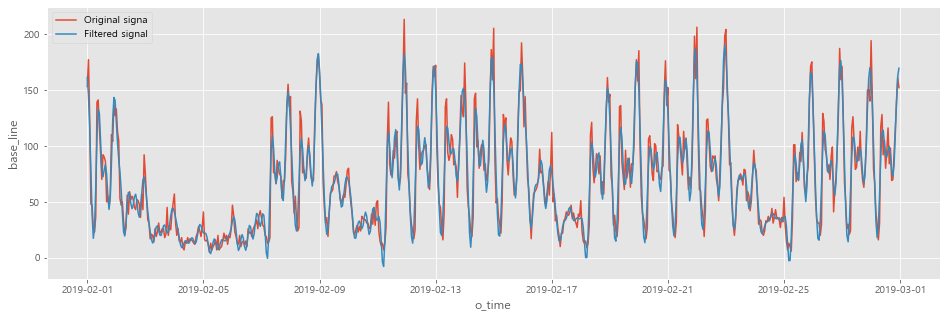

In [946]:
plt.figure(figsize=(16, 5))
sns.lineplot(x=fft_result['2019-02'].index,y='count',data=fft_result['2019-02'])
sns.lineplot(x=fft_result['2019-02'].index,y='base_line',data=fft_result['2019-02'])
plt.legend(['Original signa','Filtered signal'])

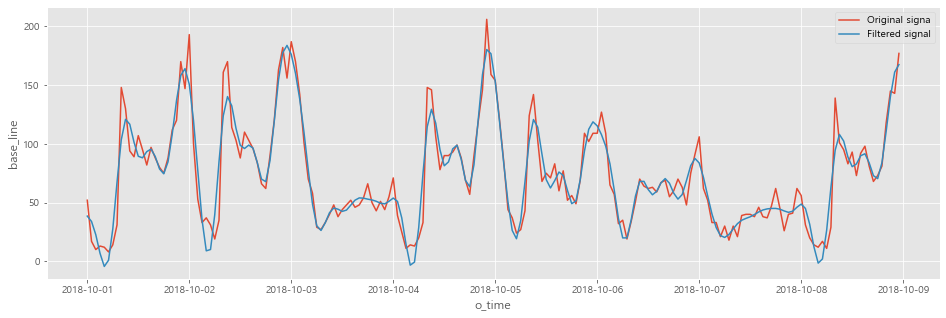

In [947]:
plt.figure(figsize=(16, 5))
sns.lineplot(x=fft_result['2018-10-01':'2018-10-08'].index,y='count',data=fft_result['2018-10-01':'2018-10-08'])
sns.lineplot(x=fft_result['2018-10-01':'2018-10-08'].index,y='base_line',data=fft_result['2018-10-01':'2018-10-08'])
plt.legend(['Original signa','Filtered signal'])

### 잔차 기본 예측 결과 확인

In [948]:
residual = fft_result['count'].values - fft_result['base_line'].values

In [949]:
taxi['residual'] = residual

In [899]:
taxi.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,residual,pred
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,4.592121,57.880289
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,-4.050835,16.921812
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,4.536149,12.893408
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,-1.642804,18.190300
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,-6.274813,8.470343


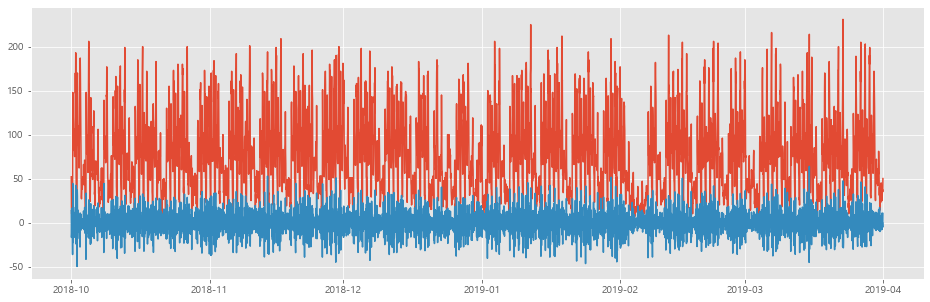

In [950]:
plt.figure(figsize=(16, 5))
plt.plot(taxi.set_index('o_time')['count'])
plt.plot(taxi.set_index('o_time')['residual'])

In [941]:
test = taxi.reset_index(inplace=False)
test.drop(['index','o_time','count','pred'],axis=1,inplace=True)
test

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,residual
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,3.765527
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,-3.489274
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,0.981875
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,1.629033
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,-1.490603
5,5,100,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,-2.761198
6,6,100,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,9.651309
7,7,100,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,-15.516674
8,8,100,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,16.845906
9,9,100,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,-12.677209


#### 상관관계 확인

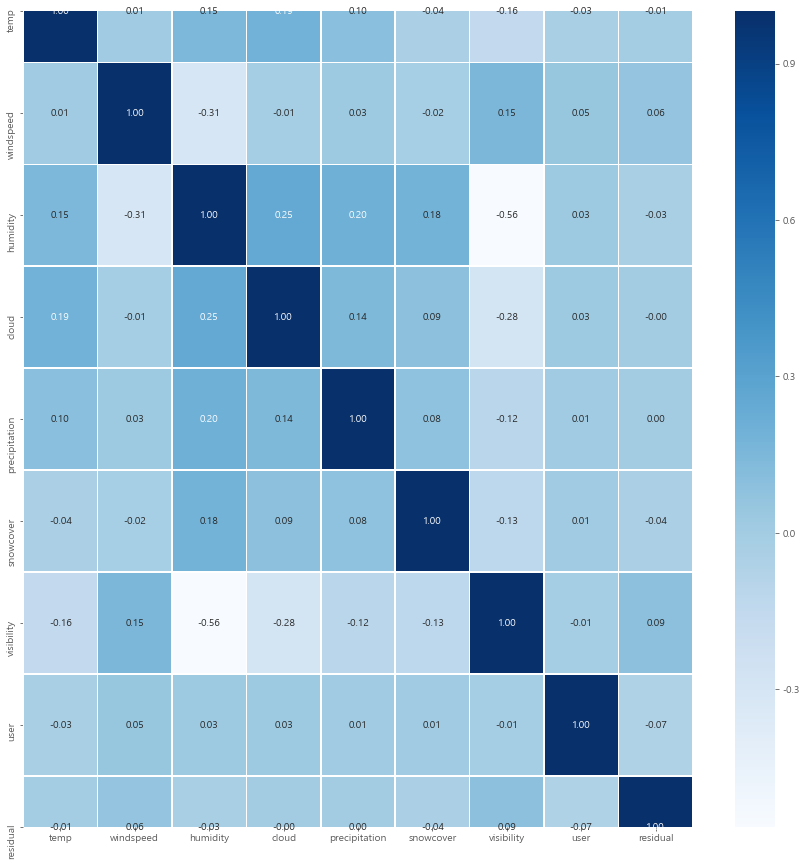

In [879]:
plt.figure(figsize=(15,15))
sns.heatmap(data = test.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [942]:
y_target1 = test['residual']
X_data1 = test.drop(['residual'], axis=1, inplace=False)

In [943]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_target1, test_size=0.3, random_state=12)

#### 성능평가 함수 

In [178]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    mae_val = mean_absolute_error(y,pred)
    mse_val = mean_squared_error(y,pred)
    rmse_val = rmse(y,pred)
    rmsle_val = rmsle(y,pred)
    print('MAE : {0:.3f}, MSE : {1:.3F}, RMSE : {2:.3F}, RMSLE : {3:.3F}'.format(mae_val,mse_val,rmse_val,rmsle_val))

#### 확인

##### RandomForest

In [944]:
rf_model = RandomForestRegressor(max_depth = 8, n_estimators=800, max_leaf_nodes=1200)
rf_model.fit(X_train1, y_train1)
pred = rf_model.predict(X_test1)

evaluate_regr(y_test1,pred)

MAE : 4.983, MSE : 41.201, RMSE : 6.419, RMSLE : 1.829


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log1p

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in log1p



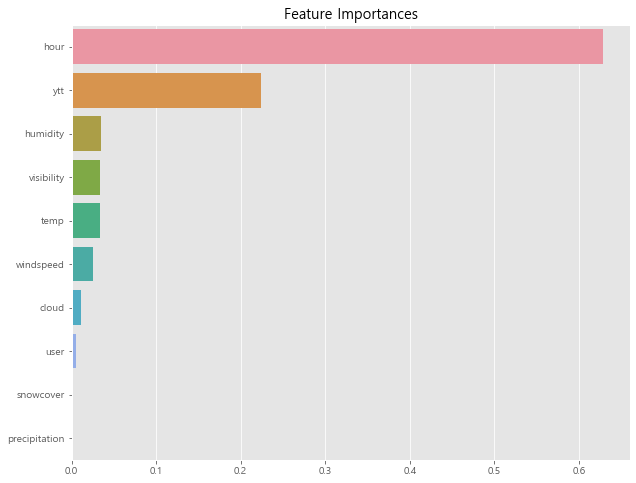

In [929]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

__전체데이터__

In [770]:
total_data = test.drop('residual',axis=1,inplace=False)

In [806]:
total_data

,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user
0,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0
1,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0
2,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0
3,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0
4,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0
5,5,100,13.7,1.8,57,8.0,0.0,0.0,1999,1.0
6,6,100,13.3,2.3,56,7.0,0.0,0.0,2000,1.0
7,7,100,13.1,2.1,58,3.0,0.0,0.0,1997,1.0
8,8,100,13.7,2.4,54,7.0,0.0,0.0,1960,1.0
9,9,100,14.9,3.4,50,1.0,0.0,0.0,1989,1.0


In [884]:
rf_model = RandomForestRegressor(max_depth = 8, n_estimators=800, max_leaf_nodes=1200)
rf_model.fit(X_train1, y_train1)
pred = rf_model.predict(total_data)

evaluate_regr(test['residual'],pred)

MAE : 6.246, MSE : 64.809, RMSE : 8.050, RMSLE : 0.787


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log1p

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in log1p



In [885]:
taxi['pred'] = fft_result['base_line'].values + pred
taxi.head()

,o_time,hour,ytt,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,residual,pred
0,2018-10-01 00:00:00,0,100,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,-20.452678,57.880289
1,2018-10-01 01:00:00,1,100,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,-15.251880,16.921812
2,2018-10-01 02:00:00,2,100,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,-17.926759,12.893408
3,2018-10-01 03:00:00,3,100,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,-20.154054,18.190300
4,2018-10-01 04:00:00,4,100,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,-11.150212,8.470343


__전체 기간__

In [890]:
evaluate_regr(taxi['count'],taxi['pred'])

MAE : 6.246, MSE : 64.809, RMSE : 8.050, RMSLE : 0.188


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in log1p



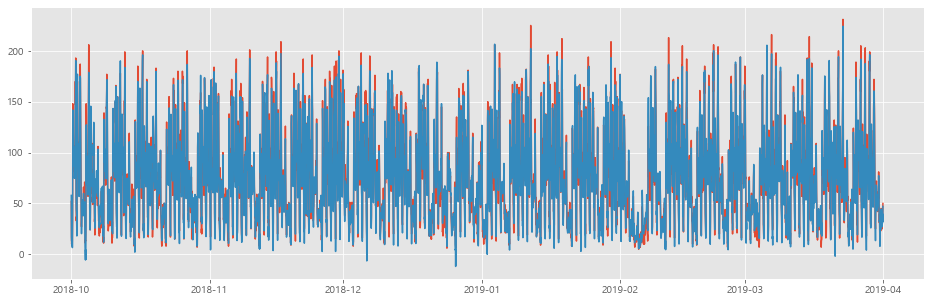

In [886]:
plt.figure(figsize=(16,5))
plt.plot(taxi.set_index('o_time')['count'])
plt.plot(taxi.set_index('o_time')['pred'])

__한달__

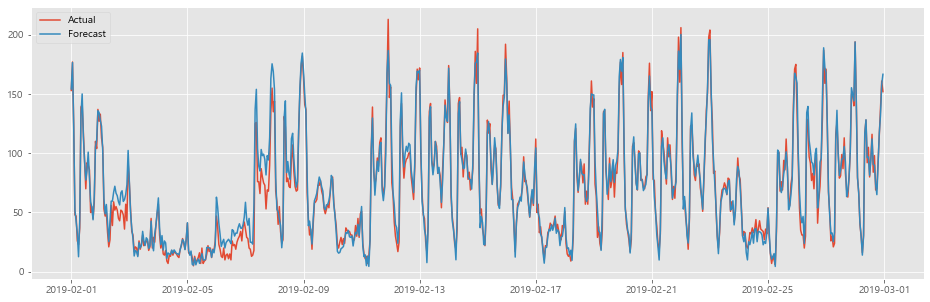

In [887]:
plt.figure(figsize=(16,5))
plt.plot(taxi.set_index('o_time')['2019-02']['count'])
plt.plot(taxi.set_index('o_time')['2019-02']['pred'])
plt.legend(['Actual','Forecast'])
plt.show()

__일주일__

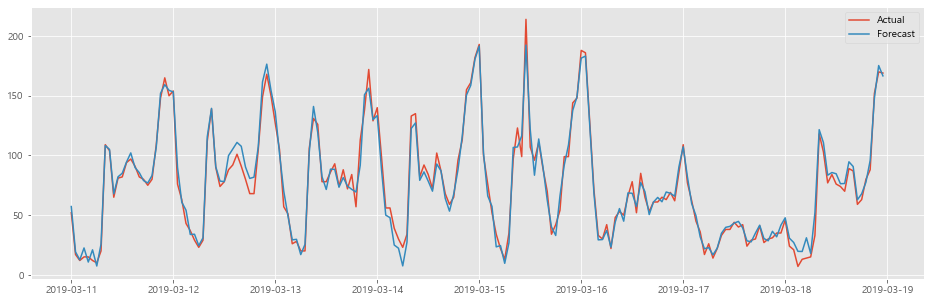

In [888]:
plt.figure(figsize=(16,5))
plt.plot(taxi.set_index('o_time')['2019-03-11':'2019-03-18']['count'])
plt.plot(taxi.set_index('o_time')['2019-03-11':'2019-03-18']['pred'])
plt.legend(['Actual','Forecast'])
plt.show()

##### XGBoost

In [643]:
test = pd.get_dummies(test, columns=['hour','ytt'])

In [644]:
y_target1 = test['residual']
X_data1 = test.drop(['residual'], axis=1, inplace=False)

In [645]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_target1, test_size=0.3, random_state=12)

In [646]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=12, gamma=5, nthread=4, subsample=0.8, min_child_weight=7)

evals = [(X_test1,y_test1)]

xgb_model.fit(X_train1, y_train1, early_stopping_rounds=200, eval_set = evals,eval_metric='rmse')
pred = xgb_model.predict(X_test1)

[10:34:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.3585
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:31.3242
[2]	validation_0-rmse:30.3483
[3]	validation_0-rmse:29.4269
[4]	validation_0-rmse:28.5956
[5]	validation_0-rmse:27.8208
[6]	validation_0-rmse:27.0584
[7]	validation_0-rmse:26.3658
[8]	validation_0-rmse:25.6904
[9]	validation_0-rmse:25.0324
[10]	validation_0-rmse:24.465
[11]	validation_0-rmse:23.9228
[12]	validation_0-rmse:23.4238
[13]	validation_0-rmse:22.8596
[14]	validation_0-rmse:22.4169
[15]	validation_0-rmse:21.9522
[16]	validation_0-rmse:21.5169
[17]	validation_0-rmse:21.0726
[18]	validation_0-rmse:20.7121
[19]	validation_0-rmse:20.3531
[20]	validation_0-rmse:19.9772
[21]	validation_0-rmse:19.6473
[22]	validation_0-rmse:19.3508


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[23]	validation_0-rmse:19.052
[24]	validation_0-rmse:18.7621
[25]	validation_0-rmse:18.5035
[26]	validation_0-rmse:18.2625
[27]	validation_0-rmse:18.0124
[28]	validation_0-rmse:17.8009
[29]	validation_0-rmse:17.6118
[30]	validation_0-rmse:17.4117
[31]	validation_0-rmse:17.2366
[32]	validation_0-rmse:17.0077
[33]	validation_0-rmse:16.8231
[34]	validation_0-rmse:16.6225
[35]	validation_0-rmse:16.4634
[36]	validation_0-rmse:16.3256
[37]	validation_0-rmse:16.2069
[38]	validation_0-rmse:16.0704
[39]	validation_0-rmse:15.9362
[40]	validation_0-rmse:15.8256
[41]	validation_0-rmse:15.6424
[42]	validation_0-rmse:15.51
[43]	validation_0-rmse:15.3785
[44]	validation_0-rmse:15.311
[45]	validation_0-rmse:15.1845
[46]	validation_0-rmse:15.0803
[47]	validation_0-rmse:14.9993
[48]	validation_0-rmse:14.9077
[49]	validation_0-rmse:14.835
[50]	validation_0-rmse:14.701
[51]	validation_0-rmse:14.6404
[52]	validation_0-rmse:14.5785
[53]	validation_0-rmse:14.4752
[54]	validation_0-rmse:14.4292
[55]	validatio

[283]	validation_0-rmse:13.1764
[284]	validation_0-rmse:13.1753
[285]	validation_0-rmse:13.1723
[286]	validation_0-rmse:13.1781
[287]	validation_0-rmse:13.1786
[288]	validation_0-rmse:13.1804
[289]	validation_0-rmse:13.1799
[290]	validation_0-rmse:13.1835
[291]	validation_0-rmse:13.1874
[292]	validation_0-rmse:13.186
[293]	validation_0-rmse:13.1884
[294]	validation_0-rmse:13.1897
[295]	validation_0-rmse:13.1941
[296]	validation_0-rmse:13.1951
[297]	validation_0-rmse:13.1964
[298]	validation_0-rmse:13.1978
[299]	validation_0-rmse:13.1972
[300]	validation_0-rmse:13.1978
[301]	validation_0-rmse:13.1949
[302]	validation_0-rmse:13.1943
[303]	validation_0-rmse:13.193
[304]	validation_0-rmse:13.1931
[305]	validation_0-rmse:13.1966
[306]	validation_0-rmse:13.1992
[307]	validation_0-rmse:13.1982
[308]	validation_0-rmse:13.1994
[309]	validation_0-rmse:13.2034
[310]	validation_0-rmse:13.2047
[311]	validation_0-rmse:13.2067
[312]	validation_0-rmse:13.2049
[313]	validation_0-rmse:13.206
[314]	valid

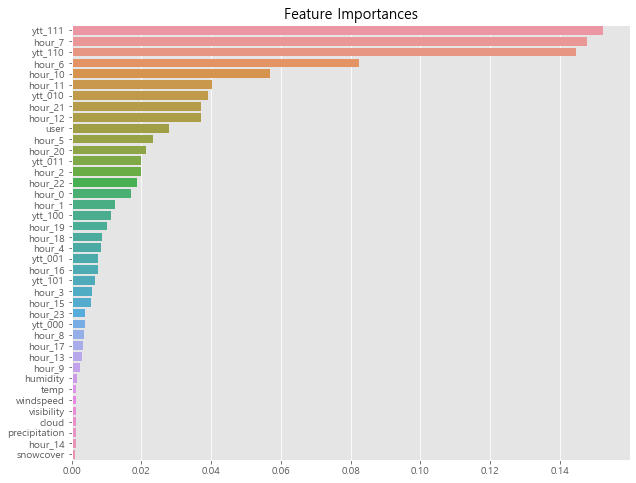

In [647]:
ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train1.columns).sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(x=ftr_importances, y=ftr_importances.index)
plt.show()

## Prophet

In [337]:
taxi

,o_time,yesterday,today,tomorrow,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,residual
0,2018-10-01 00:00:00,1,0,0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,-34.662632
1,2018-10-01 01:00:00,1,0,0,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,-51.657588
2,2018-10-01 02:00:00,1,0,0,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,-37.179452
3,2018-10-01 03:00:00,1,0,0,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,-18.935462
4,2018-10-01 04:00:00,1,0,0,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,-18.563969
5,2018-10-01 05:00:00,1,0,0,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,8,-36.803187
6,2018-10-01 06:00:00,1,0,0,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,14,-55.619477
7,2018-10-01 07:00:00,1,0,0,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,31,-64.722265
8,2018-10-01 08:00:00,1,0,0,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,148,33.945771
9,2018-10-01 09:00:00,1,0,0,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,130,10.181732


In [495]:
df = taxi[['o_time','residual']]
df.rename(columns={'o_time':'ds','residual':'y'},inplace=True)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ds,y
0,2018-10-01 00:00:00,-34.662632
1,2018-10-01 01:00:00,-51.657588
2,2018-10-01 02:00:00,-37.179452
3,2018-10-01 03:00:00,-18.935462
4,2018-10-01 04:00:00,-18.563969


In [502]:
df['cap'] = 100
#df['floor'] = 10

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [496]:
df.tail()

,ds,y
4363,2019-03-31 19:00:00,-39.495694
4364,2019-03-31 20:00:00,-30.341912
4365,2019-03-31 21:00:00,-41.904443
4366,2019-03-31 22:00:00,-55.025348
4367,2019-03-31 23:00:00,-44.173433


In [411]:
fu = pd.date_range('2018-10-01 00:00:00', periods=5088 , freq='h')
fu

DatetimeIndex(['2018-10-01 00:00:00', '2018-10-01 01:00:00',
               '2018-10-01 02:00:00', '2018-10-01 03:00:00',
               '2018-10-01 04:00:00', '2018-10-01 05:00:00',
               '2018-10-01 06:00:00', '2018-10-01 07:00:00',
               '2018-10-01 08:00:00', '2018-10-01 09:00:00',
               ...
               '2019-04-30 14:00:00', '2019-04-30 15:00:00',
               '2019-04-30 16:00:00', '2019-04-30 17:00:00',
               '2019-04-30 18:00:00', '2019-04-30 19:00:00',
               '2019-04-30 20:00:00', '2019-04-30 21:00:00',
               '2019-04-30 22:00:00', '2019-04-30 23:00:00'],
              dtype='datetime64[ns]', length=5088, freq='H')

In [412]:
future = pd.Series(range(len(fu)),index=fu).to_frame().reset_index()
future.rename(columns={'index':'ds'},inplace=True)
future.drop(0,axis=1,inplace=True)

In [492]:
future['cap'] = 250
future['floor'] = 10

In [510]:
m1 = Prophet()
m1.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [511]:
future = m1.make_future_dataframe(periods=720 , freq='H')

In [506]:
future['cap'] = 100
#future['floor'] = 10

In [512]:
forecast = m1.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-01 00:00:00,-1.309622,-60.416709,-0.938125,-1.309622,-1.309622,-29.264728,-29.264728,-29.264728,2.426987,2.426987,2.426987,-31.691715,-31.691715,-31.691715,0.0,0.0,0.0,-30.574350
1,2018-10-01 01:00:00,-1.305531,-56.929123,0.216018,-1.305531,-1.305531,-27.880494,-27.880494,-27.880494,1.882060,1.882060,1.882060,-29.762554,-29.762554,-29.762554,0.0,0.0,0.0,-29.186025
2,2018-10-01 02:00:00,-1.301439,-55.247996,5.402211,-1.301439,-1.301439,-23.039241,-23.039241,-23.039241,4.698039,4.698039,4.698039,-27.737280,-27.737280,-27.737280,0.0,0.0,0.0,-24.340680
3,2018-10-01 03:00:00,-1.297347,-51.853608,5.358674,-1.297347,-1.297347,-22.046723,-22.046723,-22.046723,3.585205,3.585205,3.585205,-25.631929,-25.631929,-25.631929,0.0,0.0,0.0,-23.344071
4,2018-10-01 04:00:00,-1.293256,-59.253283,0.953130,-1.293256,-1.293256,-28.333121,-28.333121,-28.333121,-4.870151,-4.870151,-4.870151,-23.462970,-23.462970,-23.462970,0.0,0.0,0.0,-29.626377
5,2018-10-01 05:00:00,-1.289164,-69.821291,-8.435413,-1.289164,-1.289164,-37.730578,-37.730578,-37.730578,-16.483433,-16.483433,-16.483433,-21.247145,-21.247145,-21.247145,0.0,0.0,0.0,-39.019743
6,2018-10-01 06:00:00,-1.285073,-71.166243,-16.061665,-1.285073,-1.285073,-42.366386,-42.366386,-42.366386,-23.365087,-23.365087,-23.365087,-19.001299,-19.001299,-19.001299,0.0,0.0,0.0,-43.651459
7,2018-10-01 07:00:00,-1.280981,-69.567933,-11.561933,-1.280981,-1.280981,-38.298404,-38.298404,-38.298404,-21.556184,-21.556184,-21.556184,-16.742220,-16.742220,-16.742220,0.0,0.0,0.0,-39.579385
8,2018-10-01 08:00:00,-1.276890,-60.269064,-3.490078,-1.276890,-1.276890,-29.274545,-29.274545,-29.274545,-14.788072,-14.788072,-14.788072,-14.486473,-14.486473,-14.486473,0.0,0.0,0.0,-30.551435
9,2018-10-01 09:00:00,-1.272798,-53.430394,5.957820,-1.272798,-1.272798,-22.870270,-22.870270,-22.870270,-10.620028,-10.620028,-10.620028,-12.250242,-12.250242,-12.250242,0.0,0.0,0.0,-24.143068


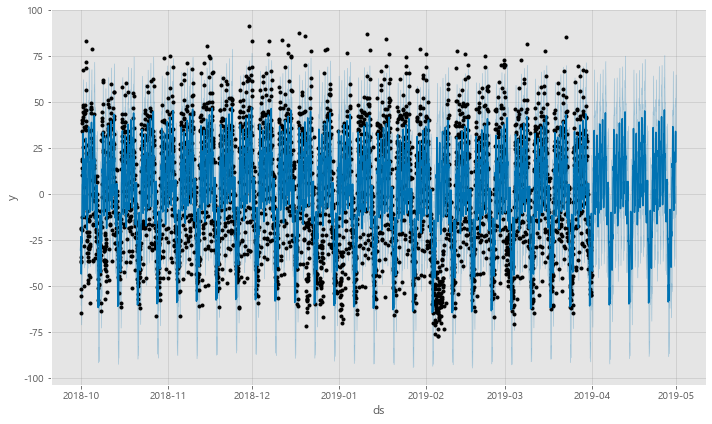

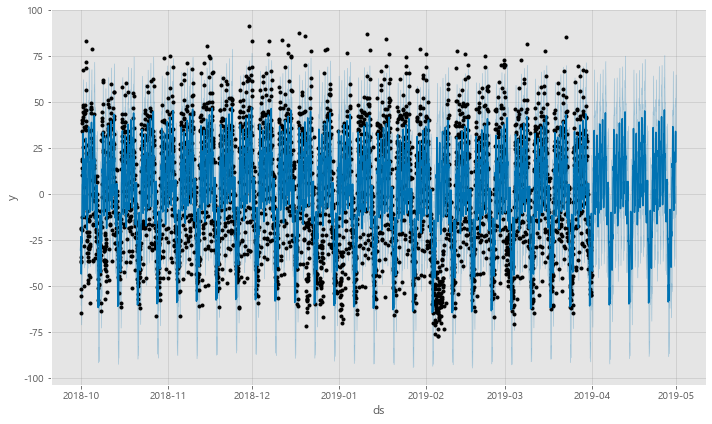

In [513]:
m1.plot(forecast)

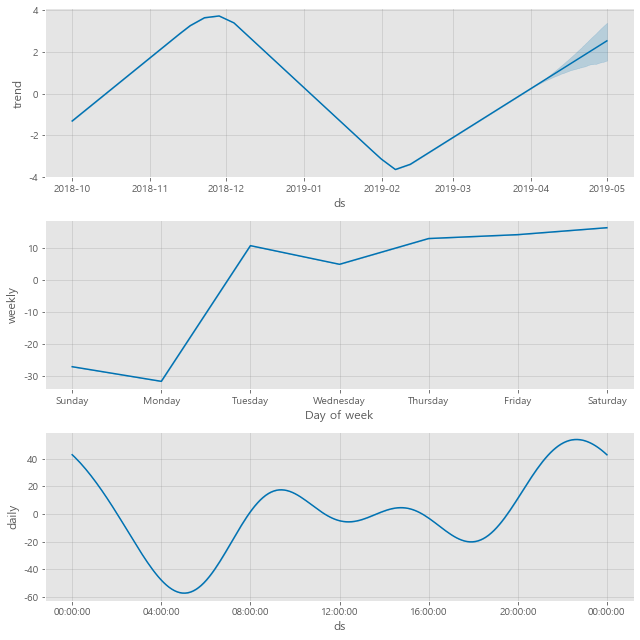

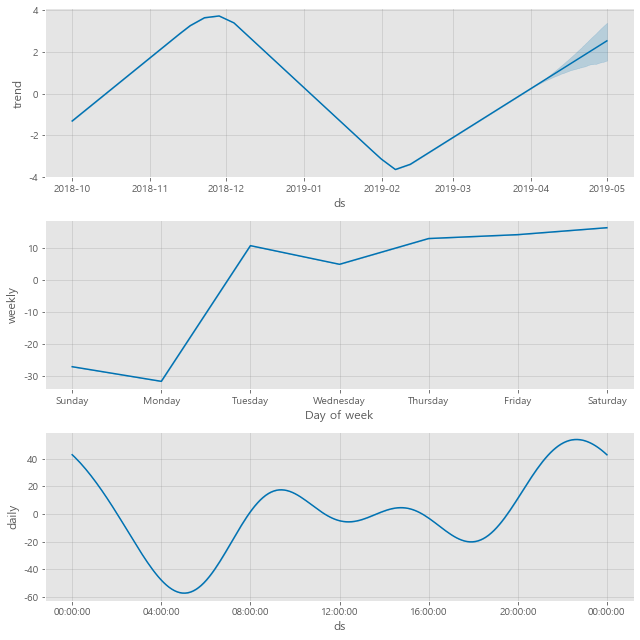

In [514]:
m.plot_components(forecast)

## ARIMA

In [425]:
df2 = df[['ds','y']]
df2.head()

,ds,y
0,2018-10-01 00:00:00,52
1,2018-10-01 01:00:00,17
2,2018-10-01 02:00:00,10
3,2018-10-01 03:00:00,13
4,2018-10-01 04:00:00,12


In [429]:
df2.set_index('ds',inplace=True)

In [439]:
31*24

744

In [440]:
4368-744

3624

In [442]:
df2 = df2[:3624]
df2.tail()

,y
ds,
2019-02-28 19:00:00,92
2019-02-28 20:00:00,116
2019-02-28 21:00:00,138
2019-02-28 22:00:00,161
2019-02-28 23:00:00,152


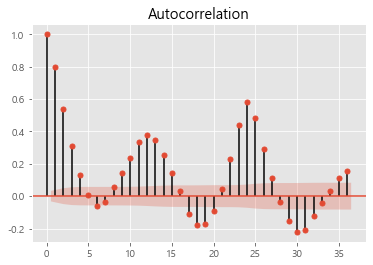

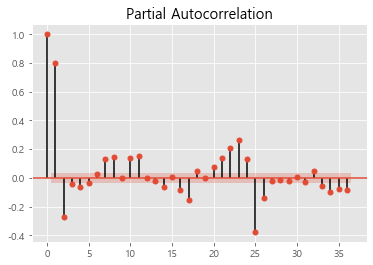

In [529]:
plot_acf(df2)
plot_pacf(df2)
plt.show()

In [548]:
model = ARIMA(df2, order=(0,1,1),freq='H')
model_fit = model.fit(trend='nc',full_output = True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3623
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -17187.825
Method:                       css-mle   S.D. of innovations             27.803
Date:                Mon, 18 May 2020   AIC                          34379.650
Time:                        19:47:33   BIC                          34392.040
Sample:                    10-01-2018   HQIC                         34384.064
                         - 02-28-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y      0.1702      0.017      9.874      0.000       0.136       0.204
                                    Roots                                    
                  Real          Imaginary           M

In [546]:
model_fit.forecast(300)

(array([149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.89277601, 149.89277601,
        149.89277601, 149.89277601, 149.

In [524]:
fore = model_fit.predict(1,4500,typ='levels')
print(fore)

2018-10-01 01:00:00     25.556104
2018-10-01 02:00:00     -5.544120
2018-10-01 03:00:00     11.208895
2018-10-01 04:00:00      1.363470
2018-10-01 05:00:00      8.352244
2018-10-01 06:00:00     -0.281909
2018-10-01 07:00:00     11.569758
2018-10-01 08:00:00     15.866084
2018-10-01 09:00:00    108.468971
2018-10-01 10:00:00     17.737989
2018-10-01 11:00:00     62.979341
2018-10-01 12:00:00     21.524058
2018-10-01 13:00:00     70.784726
2018-10-01 14:00:00     20.068776
2018-10-01 15:00:00     51.353707
2018-10-01 16:00:00     37.863977
2018-10-01 17:00:00     41.598694
2018-10-01 18:00:00     31.867714
2018-10-01 19:00:00     35.798029
2018-10-01 20:00:00     43.329051
2018-10-01 21:00:00     57.001971
2018-10-01 22:00:00     52.295064
2018-10-01 23:00:00     97.710236
2018-10-02 00:00:00     40.917600
2018-10-02 01:00:00    126.251896
2018-10-02 02:00:00    -21.793322
2018-10-02 03:00:00     62.090938
2018-10-02 04:00:00    -24.150433
2018-10-02 05:00:00     50.765421
2018-10-02 06: